# Improvements:
- Split casual and registered - completed
- create two separate models + test combined model - completed
- undersample summer/spring - oversample fall/winter - unfinished (unsure if this is necessary)
- reevaluate minmax (fix data leak) - completed
- add tuner - completed
- work on scheduler - integrate into tuner - completed

# Pre-Processing

## Imports

In [1]:
# pip install tensorflow keras-tuner

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
import math
from tensorflow.keras import layers
import keras_tuner as kt
from kerastuner.tuners import Hyperband
# from google.colab import drive
# drive.mount('/content/drive')
import os
num_threads = os.cpu_count()  # get the number of CPU cores

tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)
my_drive_dir = 'C:/Users/jared/Documents/GitHub/CSE450-Team/Project_3/Jared-Work'

# loading in the bikes csv
bikes_df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
bikes_mini = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv')
bikes_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv')

# check out the info
bikes_df.info()
# holdout_X = holdout_X.reindex(columns=X.columns)
# holdout_X = fill.na(0)

C:\Users\jared\AppData\Local\Temp\ipykernel_20128\3539675626.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dteday        16637 non-null  object 
 1   season        16637 non-null  int64  
 2   hr            16637 non-null  int64  
 3   holiday       16637 non-null  int64  
 4   workingday    16637 non-null  int64  
 5   weathersit    16637 non-null  int64  
 6   hum           16637 non-null  float64
 7   windspeed     16637 non-null  int64  
 8   temp_c        16637 non-null  float64
 9   feels_like_c  16637 non-null  float64
 10  casual        16637 non-null  int64  
 11  registered    16637 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.5+ MB


In [3]:
bikes_holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dteday        742 non-null    object 
 1   season        742 non-null    int64  
 2   hr            742 non-null    int64  
 3   holiday       742 non-null    int64  
 4   workingday    742 non-null    int64  
 5   weathersit    742 non-null    int64  
 6   hum           742 non-null    float64
 7   windspeed     742 non-null    int64  
 8   temp_c        742 non-null    float64
 9   feels_like_c  742 non-null    float64
dtypes: float64(3), int64(6), object(1)
memory usage: 58.1+ KB


In [4]:
bikes_df.head()

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
0,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13
1,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32
2,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27
3,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10
4,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1


In [5]:
bikes_mini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dteday        35 non-null     object 
 1   season        35 non-null     int64  
 2   hr            35 non-null     int64  
 3   holiday       35 non-null     int64  
 4   workingday    35 non-null     int64  
 5   weathersit    35 non-null     int64  
 6   hum           35 non-null     float64
 7   windspeed     35 non-null     int64  
 8   temp_c        35 non-null     float64
 9   feels_like_c  35 non-null     float64
dtypes: float64(3), int64(6), object(1)
memory usage: 2.9+ KB


In [6]:
bikes_mini.head()

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c
0,12/1/12,4,0,0,0,1,0.81,0,4.22,3.9980
1,12/1/12,4,1,0,0,1,0.81,0,4.22,3.9980
2,12/1/12,4,2,0,0,2,0.81,0,4.22,3.9980
3,12/1/12,4,3,0,0,2,0.81,9,4.22,1.9982
4,12/1/12,4,4,0,0,1,0.81,6,4.22,3.0014


In [7]:
bikes_holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dteday        742 non-null    object 
 1   season        742 non-null    int64  
 2   hr            742 non-null    int64  
 3   holiday       742 non-null    int64  
 4   workingday    742 non-null    int64  
 5   weathersit    742 non-null    int64  
 6   hum           742 non-null    float64
 7   windspeed     742 non-null    int64  
 8   temp_c        742 non-null    float64
 9   feels_like_c  742 non-null    float64
dtypes: float64(3), int64(6), object(1)
memory usage: 58.1+ KB


In [8]:
bikes_holdout.head()

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c
0,12/1/12,4,0,0,0,1,0.81,0,4.22,3.9980
1,12/1/12,4,1,0,0,1,0.81,0,4.22,3.9980
2,12/1/12,4,2,0,0,2,0.81,0,4.22,3.9980
3,12/1/12,4,3,0,0,2,0.81,9,4.22,1.9982
4,12/1/12,4,4,0,0,1,0.81,6,4.22,3.0014


In [9]:
# Preprocessing 
bikes_df.head()
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'], format='%m/%d/%y')
bikes_mini['dteday'] = pd.to_datetime(bikes_mini['dteday'], format='%m/%d/%y')
bikes_holdout['dteday'] = pd.to_datetime(bikes_holdout['dteday'], format='%m/%d/%y')

# create new features - year, month, day, dayofweek
bikes_df['year'] = pd.to_datetime(bikes_df['dteday']).dt.year
bikes_df['month'] = pd.to_datetime(bikes_df['dteday']).dt.month
bikes_df['day'] = pd.to_datetime(bikes_df['dteday']).dt.day
bikes_df['dayofweek'] = pd.to_datetime(bikes_df['dteday']).dt.dayofweek

bikes_mini['year'] = pd.to_datetime(bikes_mini['dteday']).dt.year
bikes_mini['month'] = pd.to_datetime(bikes_mini['dteday']).dt.month
bikes_mini['day'] = pd.to_datetime(bikes_mini['dteday']).dt.day
bikes_mini['dayofweek'] = pd.to_datetime(bikes_mini['dteday']).dt.dayofweek

bikes_holdout['year'] = pd.to_datetime(bikes_holdout['dteday']).dt.year
bikes_holdout['month'] = pd.to_datetime(bikes_holdout['dteday']).dt.month
bikes_holdout['day'] = pd.to_datetime(bikes_holdout['dteday']).dt.day
bikes_holdout['dayofweek'] = pd.to_datetime(bikes_holdout['dteday']).dt.dayofweek

# One hot encoding
categorical_features = ['season', 'hr', 'holiday', 'workingday', 'weathersit', 'year', 'month', 'day', 'dayofweek']
for df in [bikes_df, bikes_mini, bikes_holdout]:
    df = pd.get_dummies(df, columns=categorical_features, dtype=int)

# holiday 
for df in [bikes_df, bikes_mini, bikes_holdout]:
    df['is_christmas_week'] = df.apply(lambda row: 1 if (row['month'] == 12) and (row['day'] >= 20 and row['day'] <= 31) else 0, axis=1)

# drop dteday column
bikes_df = bikes_df.drop('dteday', axis=1)
bikes_mini = bikes_mini.drop('dteday', axis=1)
bikes_holdout = bikes_holdout.drop('dteday', axis=1)

# one hot encoding
categorical_features = ['season', 'hr', 'holiday', 'workingday', 'weathersit', 'year', 'month', 'day','dayofweek']
bikes_df = pd.get_dummies(bikes_df, columns=categorical_features, dtype=int)
bikes_mini = pd.get_dummies(bikes_mini, columns=categorical_features, dtype=int)
bikes_holdout = pd.get_dummies(bikes_holdout, columns=categorical_features, dtype=int)

# features and the target
y_casual = bikes_df['casual']
y_registered = bikes_df['registered']

# X 
X = bikes_df.drop(columns=['casual', 'registered'])

# First split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X, bikes_df[['casual', 'registered']], test_size = 0.2, random_state = 42)

# Second split to separate out the test and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size = 0.5, random_state = 0)


# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Ensure bikes_mini and bikes_holdout have the same columns as X_train
bikes_mini = bikes_mini.reindex(columns = X_train.columns).fillna(0)
bikes_holdout = bikes_holdout.reindex(columns = X_train.columns).fillna(0)

# Scale bikes_mini and bikes_holdout using the scaler fitted on X_train
X_mini_scaled = scaler.transform(bikes_mini)
X_holdout_scaled = scaler.transform(bikes_holdout)

In [10]:
bikes_df.to_csv('bikes_df.csv')

In [11]:
y_train.head()

,casual,registered
13449,46,151
1085,4,40
14240,76,255
8370,20,109
1924,8,31


In [12]:
# bikes_df.head()
# bikes_df.to_csv('bikes_output1.csv', index=False)
#bikes_mini.to_csv('bikes_mini1.csv', index=False)

In [13]:
bikes_mini.head()

,hum,windspeed,temp_c,feels_like_c,is_christmas_week,season_1,season_2,season_3,season_4,hr_0,...,day_29,day_30,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.81,0,4.22,3.9980,0,0.0,0.0,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,0.81,0,4.22,3.9980,0,0.0,0.0,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,0.81,0,4.22,3.9980,0,0.0,0.0,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,0.81,9,4.22,1.9982,0,0.0,0.0,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,0.81,6,4.22,3.0014,0,0.0,0.0,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [14]:
bikes_holdout.head()

,hum,windspeed,temp_c,feels_like_c,is_christmas_week,season_1,season_2,season_3,season_4,hr_0,...,day_29,day_30,day_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.81,0,4.22,3.9980,0,0,0.0,0.0,1,1,...,0,0,0,0,0,0,0,0,1,0
1,0.81,0,4.22,3.9980,0,0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0.81,0,4.22,3.9980,0,0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0.81,9,4.22,1.9982,0,0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0.81,6,4.22,3.0014,0,0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow as tf
import os
import math

# Define the model-building function for Keras Tuner
def model_builder(hp):
    model = tf.keras.Sequential()
    n_inputs = bikes_df.shape[1] - 2  # -2 because we removed 'casual' and 'registered' columns

    # Input layer
    model.add(layers.Dense(n_inputs, input_dim=n_inputs, activation='relu'))

    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 3, 6)):
        # Tune the number of units in the i-th hidden layer
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))

    # Output layer
    model.add(layers.Dense(2, activation='linear'))  # output layer has 2 neurons

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',  # 'mean_squared_error' works with multi-output regression
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])  # update metrics to handle multi-output

    return model

# scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = LearningRateScheduler(scheduler)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

# Merge y_train['casual'] and y_train['registered'] into a single DataFrame
y_train_combined = pd.concat([y_train['casual'], y_train['registered']], axis=1)

# Adjust the tuner to work with the combined y_train
tuner_combined = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_root_mean_squared_error', direction='min'),
                     max_epochs=300,
                     factor=3,
                     directory=my_drive_dir,
                     project_name='Model_combined')

# Perform hyperparameter tuning with the combined y_train
tuner_combined.search(X_train_scaled, y_train_combined, epochs=30, validation_split=0.2, callbacks=callbacks, batch_size=64)

Trial 597 Complete [00h 00m 09s]
val_root_mean_squared_error: 24.78717041015625

Best val_root_mean_squared_error So Far: 23.613407135009766
Total elapsed time: 00h 32m 40s

Search: Running Trial #598

Value             |Best Value So Far |Hyperparameter
4                 |4                 |num_layers
192               |160               |units_0
192               |160               |units_1
192               |224               |units_2
0.01              |0.01              |learning_rate
32                |256               |units_3
224               |224               |units_4
96                |160               |units_5
100               |300               |tuner/epochs
34                |100               |tuner/initial_epoch
4                 |5                 |tuner/bracket
3                 |5                 |tuner/round
0588              |0422              |tuner/trial_id

Epoch 35/100
167/167 [==============================] - 1s 4ms/step - loss: 983.2438 - root_mean_square

In [ ]:
best_hps = tuner_combined.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'num_layers': 3, 'units_0': 160, 'units_1': 224, 'units_2': 256, 'learning_rate': 0.01, 'units_3': 256, 'units_4': 64, 'units_5': 128, 'tuner/epochs': 300, 'tuner/initial_epoch': 100, 'tuner/bracket': 5, 'tuner/round': 5, 'tuner/trial_id': '0422'}


Trial 90 Complete [00h 00m 22s]
val_root_mean_squared_error: 25.46880340576172

Best val_root_mean_squared_error So Far: 24.5953426361084
Total elapsed time: 00h 13m 24s

In [ ]:
# Get the best model
best_model_combined = tuner_combined.get_best_models(num_models=1)[0]

# Merge y_train['casual'] and y_train['registered'] into a single DataFrame
y_train_combined = pd.concat([y_train['casual'], y_train['registered']], axis=1)
y_test_combined = pd.concat([y_test['casual'], y_test['registered']], axis=1)
y_val_combined = pd.concat([y_val['casual'], y_val['registered']], axis=1)

# Evaluate the model on the training data
train_mse, train_rmse = best_model_combined.evaluate(X_train_scaled, y_train_combined, verbose = 1)

# Evaluate the model on the testing data
test_mse, test_rmse = best_model_combined.evaluate(X_test_scaled, y_test_combined, verbose = 1)

# Evaluate the model on the validation data
val_mse, val_rmse = best_model_combined.evaluate(X_val_scaled, y_val_combined, verbose = 1)

ValueError: Received incompatible tensor with shape (92,) when attempting to restore variable with shape (93,) and name dense/bias:0.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, r2_score

# Get predictions for training, testing and validation datasets
train_predictions = best_model_combined.predict(X_train_scaled)
test_predictions = best_model_combined.predict(X_test_scaled)
val_predictions = best_model_combined.predict(X_val_scaled)

# Extract 'casual' and 'registered' predictions
train_predictions_casual = train_predictions[:, 0]
train_predictions_registered = train_predictions[:, 1]

test_predictions_casual = test_predictions[:, 0]
test_predictions_registered = test_predictions[:, 1]

val_predictions_casual = val_predictions[:, 0]
val_predictions_registered = val_predictions[:, 1]

# Compute RMSE for 'casual' and 'registered'
train_rmse_casual = np.sqrt(mean_squared_error(y_train['casual'], train_predictions_casual))
train_rmse_registered = np.sqrt(mean_squared_error(y_train['registered'], train_predictions_registered))

test_rmse_casual = np.sqrt(mean_squared_error(y_test['casual'], test_predictions_casual))
test_rmse_registered = np.sqrt(mean_squared_error(y_test['registered'], test_predictions_registered))

val_rmse_casual = np.sqrt(mean_squared_error(y_val['casual'], val_predictions_casual))
val_rmse_registered = np.sqrt(mean_squared_error(y_val['registered'], val_predictions_registered))

train_r2_casual = r2_score(y_train['casual'], train_predictions_casual)
train_r2_registered = r2_score(y_train['registered'], train_predictions_registered)

test_r2_casual = r2_score(y_test['casual'], test_predictions_casual)
test_r2_registered = r2_score(y_test['registered'], test_predictions_registered)

val_r2_casual = r2_score(y_val['casual'], val_predictions_casual)
val_r2_registered = r2_score(y_val['registered'], val_predictions_registered)

# Print the RMSE scores
print(f'Train RMSE for casual: {train_rmse_casual}')
print(f'Train RMSE for registered: {train_rmse_registered}')
print(f'Test RMSE for casual: {test_rmse_casual}')
print(f'Test RMSE for registered: {test_rmse_registered}')
print(f'Validation RMSE for casual: {val_rmse_casual}')
print(f'Validation RMSE for registered: {val_rmse_registered}')
print(f'Train R2 for casual: {train_r2_casual}')
print(f'Train R2 for registered: {train_r2_registered}')
print(f'Test R2 for casual: {test_r2_casual}')
print(f'Test R2 for registered: {test_r2_registered}')
print(f'val R2 for registered: {val_r2_registered}')

52/52 [==============================] - 0s 549us/step
Train RMSE for casual: 11.175422243130775
Train RMSE for registered: 19.528483388852536
Test RMSE for casual: 14.526996755907687
Test RMSE for registered: 28.520419366063354
Validation RMSE for casual: 14.690990877801037
Validation RMSE for registered: 30.704295782040386
Train R2 for casual: 0.9497161939513374
Train R2 for registered: 0.983595153063968
Test R2 for casual: 0.9223042621899715
Test R2 for registered: 0.9621868250580496
val R2 for registered: 0.9560387689987949


416/416 [==============================] - 1s 2ms/step - loss: 336.4983 - root_mean_squared_error: 18.2342
52/52 [==============================] - 0s 5ms/step - loss: 512.3221 - root_mean_squared_error: 22.5457
52/52 [==============================] - 0s 2ms/step - loss: 577.9160 - root_mean_squared_error: 23.9563

416/416 [==============================] - 1s 2ms/step - loss: 289.7980 - root_mean_squared_error: 16.9148
52/52 [==============================] - 0s 2ms/step - loss: 459.4171 - root_mean_squared_error: 21.3479
52/52 [==============================] - 0s 2ms/step - loss: 604.3700 - root_mean_squared_error: 24.5089

In [ ]:
print(X_test_scaled.shape)

(1664, 92)


In [ ]:
y_test.shape

(1664, 2)

In [ ]:
y_test.head()

,casual,registered
4215,45,186
15865,7,32
3169,18,39
16147,268,383
12565,57,596


In [ ]:
# Get predictions for the testing data
predictions_test = best_model_combined.predict(X_test_scaled)

# Split the predictions into 'casual' and 'registered'
predictions_test_casual = predictions_test[:, 0]
predictions_test_registered = predictions_test[:, 1]

# Get the r^2 for test set
r2_test_casual = r2_score(y_test['casual'], predictions_test_casual)
r2_test_registered = r2_score(y_test['registered'], predictions_test_registered)

# Get predictions for the validation data
predictions_val = best_model_combined.predict(X_val_scaled)

predictions_val_casual = predictions_val[:,0]
predictions_val_registered = predictions_val[:,1]

# Compute the r^2 for validation set
r2_val_casual = r2_score(y_val['casual'], predictions_val_casual)  # Calculate R^2 for 'casual'
r2_val_registered = r2_score(y_val['registered'], predictions_val_registered)  # Calculate R^2 for 'registered'

# Print the R^2 scores
print(f'Test R^2 for casual: {r2_test_casual}')
print(f'Test R^2 for registered: {r2_test_registered}')
print(f'Validation R^2 for casual: {r2_val_casual}')
print(f'Validation R^2 for registered: {r2_val_registered}')

52/52 [==============================] - 0s 647us/step
Test R^2 for casual: 0.9223042621899715
Test R^2 for registered: 0.9621868250580496
Validation R^2 for casual: 0.910366481673641
Validation R^2 for registered: 0.9560387689987949


52/52 [==============================] - 0s 2ms/step
[0.92836282 0.96667423]

Epoch 1/300
167/167 [==============================] - 1s 3ms/step - loss: 6411.3940 - root_mean_squared_error: 80.0624 - val_loss: 2209.3181 - val_root_mean_squared_error: 46.9833 - lr: 0.0100
Epoch 2/300
167/167 [==============================] - 0s 2ms/step - loss: 1757.5471 - root_mean_squared_error: 41.8966 - val_loss: 2080.0015 - val_root_mean_squared_error: 45.5793 - lr: 0.0100
Epoch 3/300
167/167 [==============================] - 0s 2ms/step - loss: 1487.7921 - root_mean_squared_error: 38.5355 - val_loss: 1263.8978 - val_root_mean_squared_error: 35.5081 - lr: 0.0100
Epoch 4/300
167/167 [==============================] - 0s 2ms/step - loss: 1381.7975 - root_mean_squared_error: 37.1271 - val_loss: 1523.5820 - val_root_mean_squared_error: 38.9856 - lr: 0.0100
Epoch 5/300
167/167 [==============================] - 0s 2ms/step - loss: 1301.2141 - root_mean_squared_error: 36.0167 - val_loss: 1115.2004 - val_root_mean_squared_error: 33.3302 - lr: 0.0100
Epoch 6/300
167/167 [=========

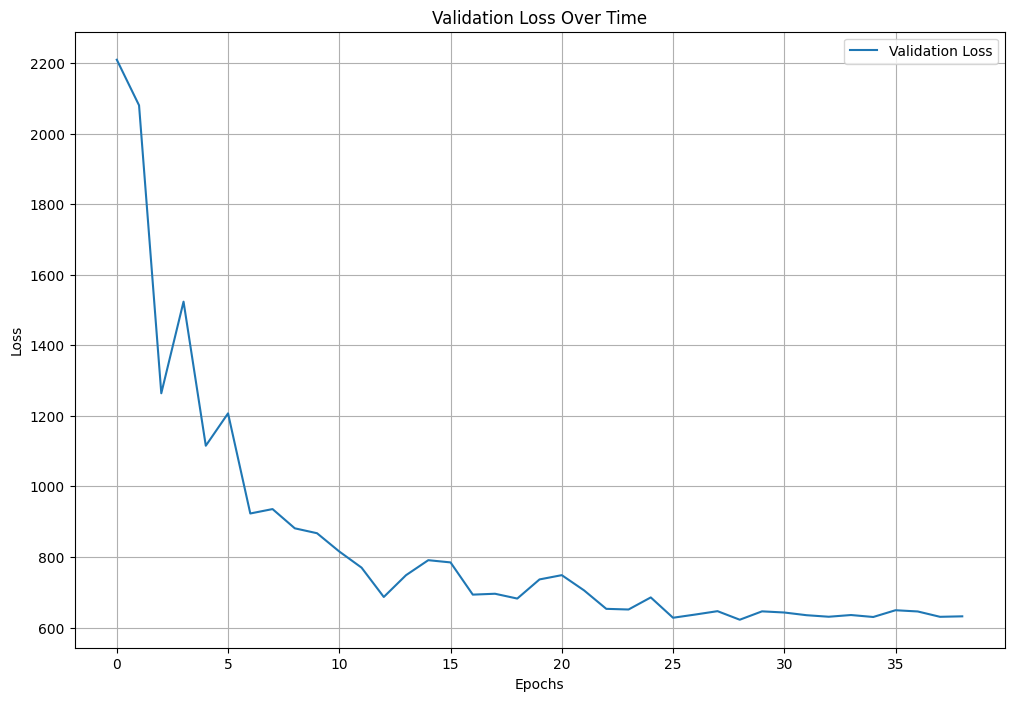

In [ ]:
import matplotlib.pyplot as plt
# Instantiate the best model with the optimal hyperparameters
best_hps = tuner_combined.get_best_hyperparameters(num_trials=1)[0]
model = tuner_combined.hypermodel.build(best_hps)

# Train the model and get the history
history = model.fit(X_train_scaled, y_train_combined, epochs=300, validation_split=0.2, callbacks=callbacks, batch_size=64)

# Plot the validation loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



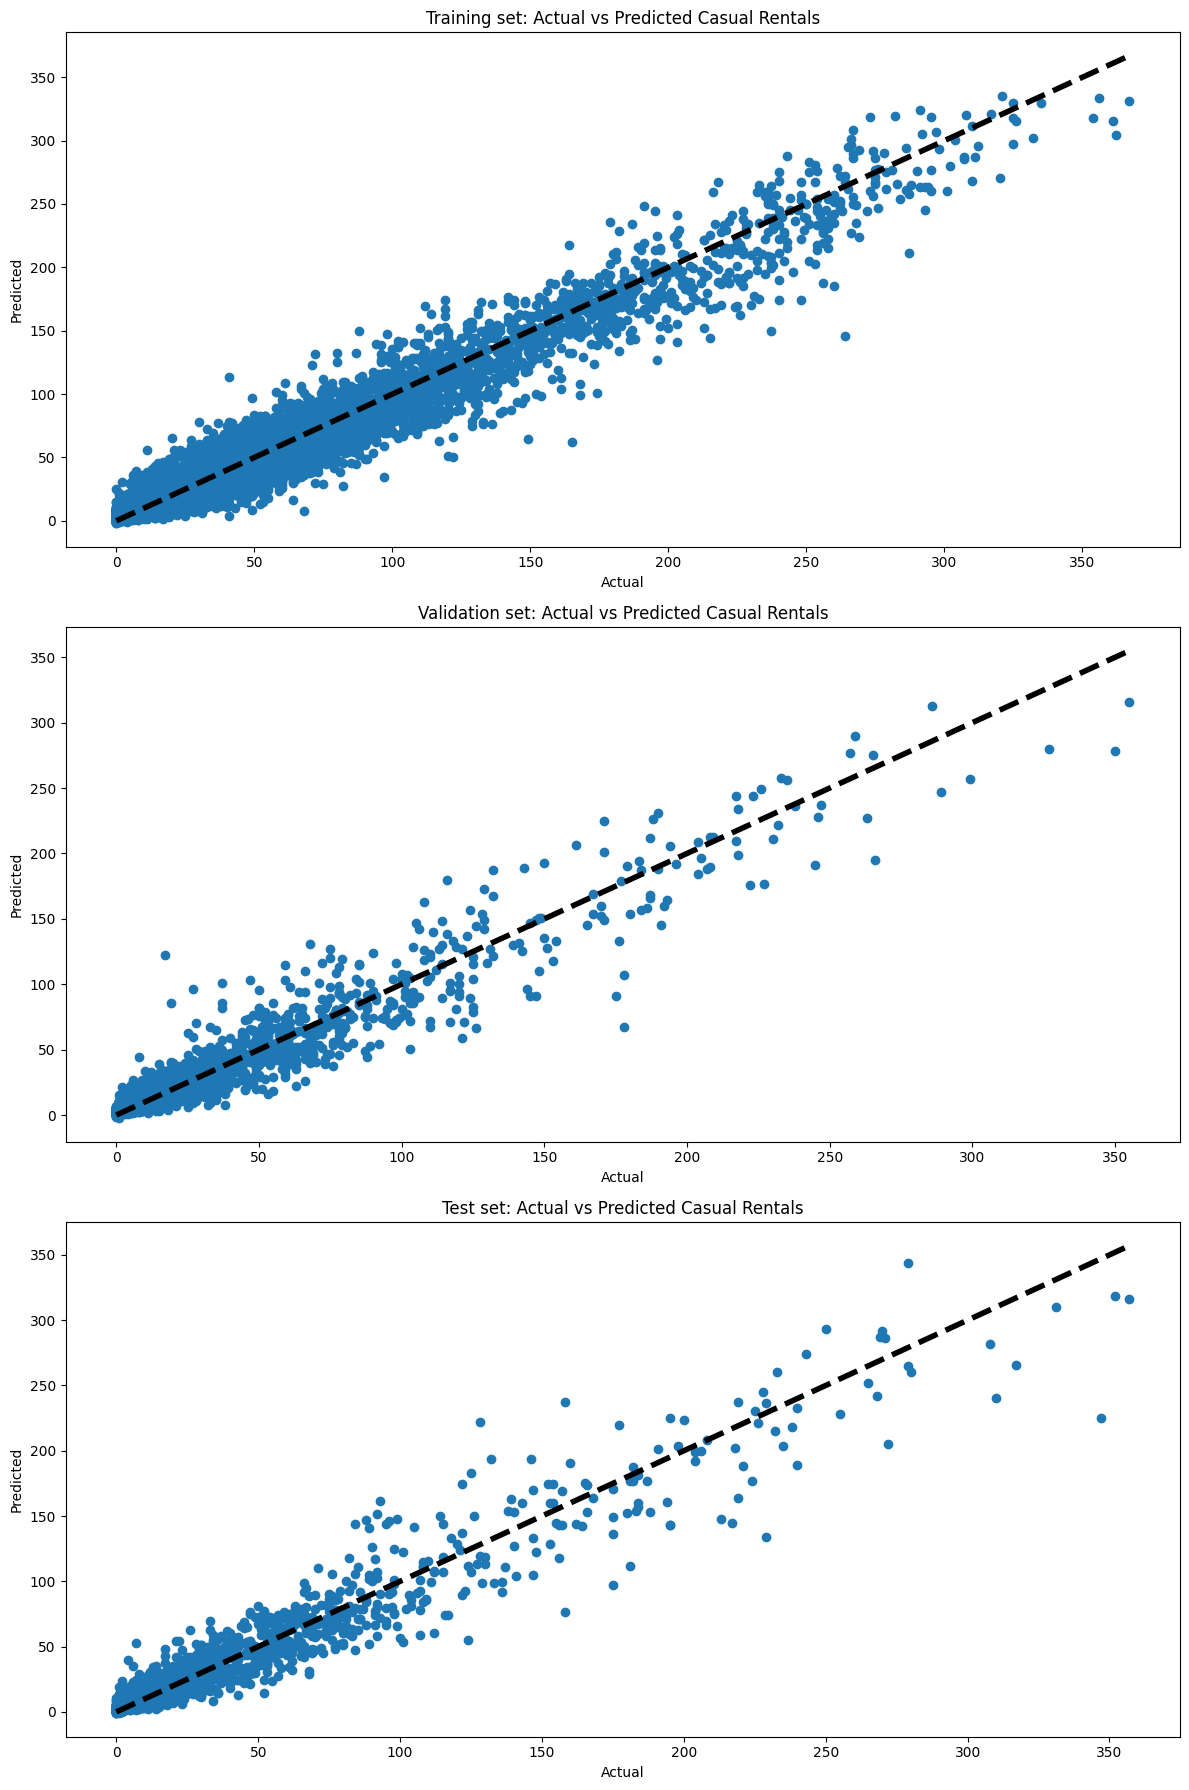

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Training set
ax[0].scatter(y_train['casual'], train_predictions_casual)
ax[0].plot([y_train['casual'].min(), y_train['casual'].max()], [y_train['casual'].min(), y_train['casual'].max()], 'k--', lw=4)
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Training set: Actual vs Predicted Casual Rentals')

# Validation set
ax[1].scatter(y_val['casual'], val_predictions_casual)
ax[1].plot([y_val['casual'].min(), y_val['casual'].max()], [y_val['casual'].min(), y_val['casual'].max()], 'k--', lw=4)
ax[1].set_xlabel('Actual')
ax[1].set_ylabel('Predicted')
ax[1].set_title('Validation set: Actual vs Predicted Casual Rentals')

# Test set
ax[2].scatter(y_test['casual'], test_predictions_casual)
ax[2].plot([y_test['casual'].min(), y_test['casual'].max()], [y_test['casual'].min(), y_test['casual'].max()], 'k--', lw=4)
ax[2].set_xlabel('Actual')
ax[2].set_ylabel('Predicted')
ax[2].set_title('Test set: Actual vs Predicted Casual Rentals')

plt.tight_layout()
plt.show()


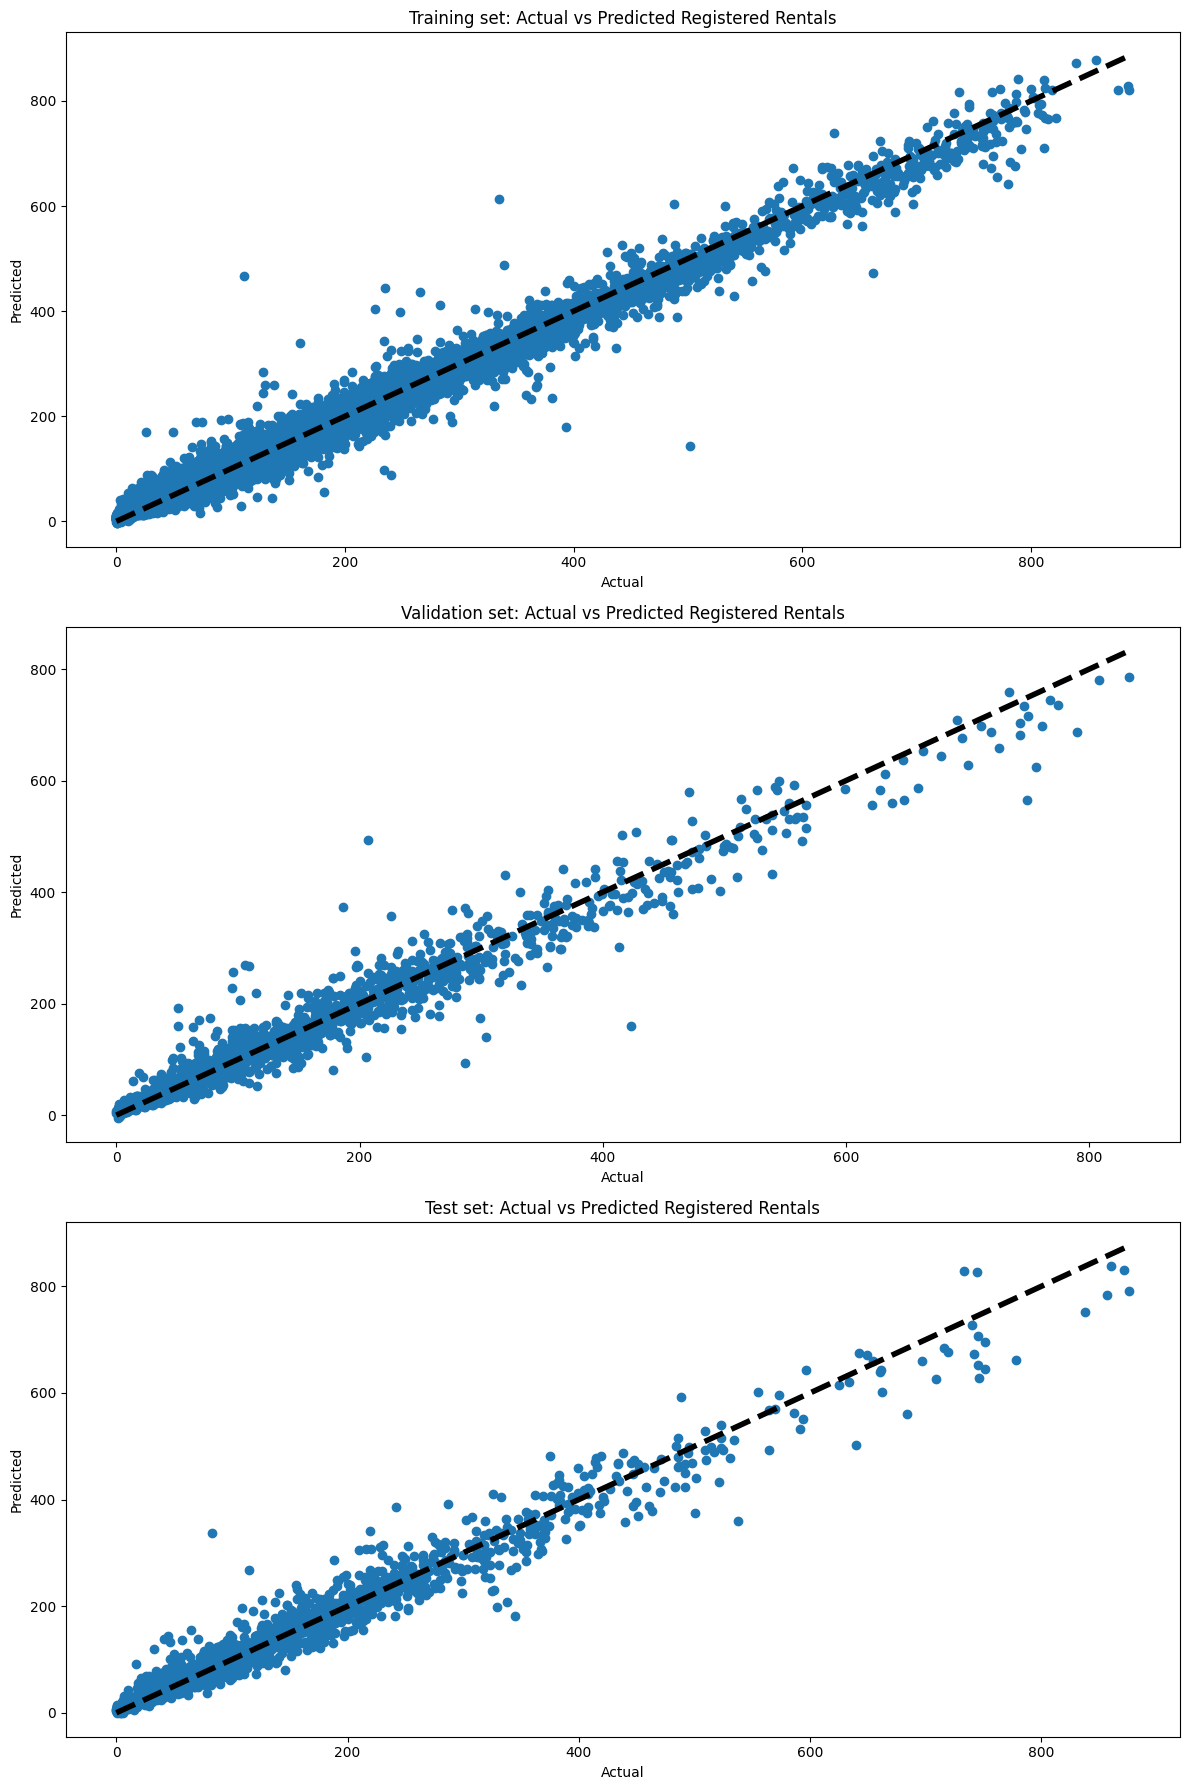

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Training set
ax[0].scatter(y_train['registered'], train_predictions_registered)
ax[0].plot([y_train['registered'].min(), y_train['registered'].max()], 
           [y_train['registered'].min(), y_train['registered'].max()], 'k--', lw=4)
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Training set: Actual vs Predicted Registered Rentals')

# Validation set
ax[1].scatter(y_val['registered'], val_predictions_registered)
ax[1].plot([y_val['registered'].min(), y_val['registered'].max()], 
           [y_val['registered'].min(), y_val['registered'].max()], 'k--', lw=4)
ax[1].set_xlabel('Actual')
ax[1].set_ylabel('Predicted')
ax[1].set_title('Validation set: Actual vs Predicted Registered Rentals')

# Test set
ax[2].scatter(y_test['registered'], test_predictions_registered)
ax[2].plot([y_test['registered'].min(), y_test['registered'].max()], 
           [y_test['registered'].min(), y_test['registered'].max()], 'k--', lw=4)
ax[2].set_xlabel('Actual')
ax[2].set_ylabel('Predicted')
ax[2].set_title('Test set: Actual vs Predicted Registered Rentals')

plt.tight_layout()
plt.show()


# Get Holdout predictions

In [ ]:
# Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print the hyperparameters
# print(best_hp.values)

NameError: name 'tuner' is not defined

{'num_layers': 2, 'units_0': 160, 'learning_rate': 0.01, 'units_1': 96, 'units_2': 160, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
best hyperparams 1

{'num_layers': 2, 'units_0': 96, 'learning_rate': 0.01, 'units_1': 160, 'units_2': 160, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

best hyperparams

In [ ]:
# import numpy as np

# targets_file = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini_answers.csv"
# targets = pd.read_csv(targets_file)
# # Assuming you already have X_mini_scaled
# predictions_mini = best_model_combined.predict(X_mini_scaled)
# y_mini = targets
# # Convert the DataFrame into a numpy array and flatten it
# y_mini_array = np.concatenate([y_mini['casual'].values, y_mini['registered'].values])
# # Assuming y_mini is the actual target values
# df_predictions = pd.DataFrame({'predictions': predictions_mini.flatten()})
# df_actual = pd.DataFrame({'actual': y_mini_array})


2/2 [==============================] - 0s 1ms/step


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# Load the holdout targets
targets_file = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini_answers.csv"
y_mini = pd.read_csv(targets_file)

# Predict the target values on the mini holdout set
predictions_mini = best_model_combined.predict(X_mini_scaled)

# Separate the predictions for 'casual' and 'registered'
predictions_mini_casual = predictions_mini[:, 0]
predictions_mini_registered = predictions_mini[:, 1]

# Convert the actual target values into numpy arrays
y_mini_casual = y_mini['casual'].values
y_mini_registered = y_mini['registered'].values

# Compute RMSE for 'casual' and 'registered'
rmse_casual = np.sqrt(mean_squared_error(y_mini_casual, predictions_mini_casual))
rmse_registered = np.sqrt(mean_squared_error(y_mini_registered, predictions_mini_registered))

# Print the RMSE scores
print(f'RMSE for casual: {rmse_casual}')
print(f'RMSE for registered: {rmse_registered}')

# Create DataFrames for actual values and predictions
df_actual_casual = pd.DataFrame({'actual_casual': y_mini_casual})
df_actual_registered = pd.DataFrame({'actual_registered': y_mini_registered})
df_predictions_casual = pd.DataFrame({'predictions_casual': predictions_mini_casual})
df_predictions_registered = pd.DataFrame({'predictions_registered': predictions_mini_registered})

# Concatenate the actual values and predictions
df_combined_casual = pd.concat([df_actual_casual, df_predictions_casual], axis=1)
df_combined_registered = pd.concat([df_actual_registered, df_predictions_registered], axis=1)

# Compute absolute differences
df_combined_casual['abs_diff'] = (df_combined_casual['actual_casual'] - df_combined_casual['predictions_casual']).abs()
df_combined_registered['abs_diff'] = (df_combined_registered['actual_registered'] - df_combined_registered['predictions_registered']).abs()

# Compute absolute difference percentages
df_combined_casual['abs_diff_pct'] = df_combined_casual['abs_diff'] / df_combined_casual['actual_casual']
df_combined_registered['abs_diff_pct'] = df_combined_registered['abs_diff'] / df_combined_registered['actual_registered']

# Plot Actual vs Predicted Values for 'casual'
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_combined_casual, x='actual_casual', y='predictions_casual')
plt.title('Actual vs Predicted for Casual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Plot Actual vs Predicted Values for 'registered'
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_combined_registered, x='actual_registered', y='predictions_registered')
plt.title('Actual vs Predicted for Registered')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Plot Residuals vs Predicted for 'casual'
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_combined_casual, x='predictions_casual', y='abs_diff')
plt.title('Residuals vs Predicted for Casual')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

# Plot Residuals vs Predicted for 'registered'
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_combined_registered, x='predictions_registered', y='abs_diff')
plt.title('Residuals vs Predicted for Registered')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

# Generate Q-Q plot for 'casual'
stats.probplot(df_combined_casual['abs_diff'], dist="norm", plot=plt)
plt.title("Normal Q-Q Plot for Casual")
plt.show()

# Generate Q-Q plot for 'registered'
stats.probplot(df_combined_registered['abs_diff'], dist="norm", plot=plt)
plt.title("Normal Q-Q Plot for Registered")
plt.show()

# Histogram of Residuals for 'casual'
plt.figure(figsize=(8,6))
sns.histplot(data=df_combined_casual, x='abs_diff', bins=30)
plt.title('Histogram of Residuals for Casual')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Histogram of Residuals for 'registered'
plt.figure(figsize=(8,6))
sns.histplot(data=df_combined_registered, x='abs_diff', bins=30)
plt.title('Histogram of Residuals for Registered')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


NameError: name 'best_model_combined' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Get predictions for training, testing and validation datasets
train_predictions = best_model_combined.predict(X_train_scaled)
test_predictions = best_model_combined.predict(X_test_scaled)
val_predictions = best_model_combined.predict(X_val_scaled)

# Extract 'casual' and 'registered' predictions
train_predictions_casual = train_predictions[:, 0]
train_predictions_registered = train_predictions[:, 1]

test_predictions_casual = test_predictions[:, 0]
test_predictions_registered = test_predictions[:, 1]

val_predictions_casual = val_predictions[:, 0]
val_predictions_registered = val_predictions[:, 1]

# Compute RMSE for 'casual' and 'registered'
train_rmse_casual = np.sqrt(mean_squared_error(y_train['casual'], train_predictions_casual))
train_rmse_registered = np.sqrt(mean_squared_error(y_train['registered'], train_predictions_registered))

test_rmse_casual = np.sqrt(mean_squared_error(y_test['casual'], test_predictions_casual))
test_rmse_registered = np.sqrt(mean_squared_error(y_test['registered'], test_predictions_registered))

val_rmse_casual = np.sqrt(mean_squared_error(y_val['casual'], val_predictions_casual))
val_rmse_registered = np.sqrt(mean_squared_error(y_val['registered'], val_predictions_registered))

# Print the RMSE scores
print(f'Train RMSE for casual: {train_rmse_casual}')
print(f'Train RMSE for registered: {train_rmse_registered}')
print(f'Test RMSE for casual: {test_rmse_casual}')
print(f'Test RMSE for registered: {test_rmse_registered}')
print(f'Validation RMSE for casual: {val_rmse_casual}')
print(f'Validation RMSE for registered: {val_rmse_registered}')

52/52 [==============================] - 0s 471us/step
Train RMSE for casual: 11.175422243130775
Train RMSE for registered: 19.528483388852536
Test RMSE for casual: 14.526996755907687
Test RMSE for registered: 28.520419366063354
Validation RMSE for casual: 14.690990877801037
Validation RMSE for registered: 30.704295782040386


In [ ]:
# Generate predictions for the holdout set
holdout_predictions = best_model_combined.predict(X_holdout_scaled)

# Extract 'casual' and 'registered' predictions
holdout_predictions_casual = holdout_predictions[:, 0]
holdout_predictions_registered = holdout_predictions[:, 1]

# Change negative predictions to 0
holdout_predictions_casual = np.clip(holdout_predictions_casual, 0, None)
holdout_predictions_registered = np.clip(holdout_predictions_registered, 0, None)

# Round up the predictions to the nearest integer
holdout_predictions_casual = np.ceil(holdout_predictions_casual)
holdout_predictions_registered = np.ceil(holdout_predictions_registered)

# Calculate total count
predictions = holdout_predictions_casual + holdout_predictions_registered

# Create a dataframe from the predictions
predictions_df = pd.DataFrame({
    'predictions': predictions
})

# Convert 'total_count' to integer
predictions_df['predictions'] = predictions_df['predictions'].astype(int)

# Save the dataframe to a csv file
predictions_df.to_csv('holdout_predictions.csv', index=False)